# Chainlink Project Analysis 

## Step 1: Scrape Data from Chainlink.ecosystem Website

In [1]:
!pip install requests beautifulsoup4 pandas
!pip install selenium --upgrade


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

In [3]:
# Navigate to the desired website
url = "https://www.chainlinkecosystem.com/ecosystem"

In [4]:
#chrome_driver_path = "/Users/mitchelschneider/Downloads/chromedriver-mac-arm64/chromedriver"

chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')  # Run Chrome in headless mode, without a GUI
chrome_options.add_argument('--no-sandbox')  # Bypass OS security model
chrome_options.add_argument('--disable-dev-shm-usage')  # Overcome limited resource problems

# Initialize the ChromeDriver without specifying executable_path
driver = webdriver.Chrome(options=chrome_options)
wait = WebDriverWait(driver, 20)

In [5]:
driver.get(url)

In [6]:
# Create an empty list to store project data and a set to track seen projects
projects_data = []
seen_project_names = set()

# Initial fetch of project containers
project_containers = driver.find_elements(By.CLASS_NAME, "ecosystem-item")
last_project_count = 0
retry_count = 0


while True:
    # Scroll to the bottom of the page
    driver.execute_script("window.scrollBy(0, 250);")
    
    try:
        # Using a wait to ensure the next set of elements is visible, modify the time as required
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, ".ecosystem-item:nth-child({})".format(last_project_count + 1))))
        retry_count = 0
    except:
        retry_count += 1
        if retry_count > 2:  # 2 retries before breaking out
            print("No new elements found after 2 retries. Exiting.")
            break
        else:
            print("Retrying scroll...")
            continue

    # Extract all the list items that represent projects
    project_containers = driver.find_elements(By.CLASS_NAME, "ecosystem-item")


    # Loop through each project container and extract relevant data
    for container in project_containers:
        project_name = container.find_element(By.CLASS_NAME, "recent-listing-head").text
        category_elements = container.find_elements(By.CSS_SELECTOR, "[fs-cmsfilter-field='Category']")
        categories = ", ".join([elem.text for elem in category_elements])
        products_elements = container.find_elements(By.CSS_SELECTOR, "[fs-cmsfilter-tagcategory='Product']")
        products = ", ".join([elem.text for elem in products_elements])
        status_element = container.find_element(By.CLASS_NAME, "listing-tag-text")
        status = status_element.text.replace('\n', '')

        if project_name not in seen_project_names:
            seen_project_names.add(project_name)
            project_data = {
                "Project Name": project_name,
                "Category": categories,
                "Product(s)": products,
                "Status": status
            }
            projects_data.append(project_data)
            
    # Checking if we reached the end. 
    if len(project_containers) == last_project_count:
        break
    last_project_count = len(project_containers)


driver.quit()

Retrying scroll...
Retrying scroll...
No new elements found after 2 retries. Exiting.


In [7]:
# Creating df for the scraped data
df = pd.DataFrame(projects_data)

In [11]:
df.head(20)

,Project Name,Category,Product(s),Status
0,GMX,"INFRASTRUCTURE, DEFI",,LIVE
1,StaFi,DEFI,,
2,Alliance Block,DEFI,,LIVE
3,Jarvis Network,INSURANCE,,LIVE
4,StackOS,"DEFI, NODE OPERATOR",,
5,DFX Finance,NFT,DATA FEEDS,LIVE
6,LittleGhosts,NFT,"DATA FEEDS, VRF",LIVE
7,ClearDAO,DEFI,DATA FEEDS,
8,Amara Finance,DEFI,DATA FEEDS,LIVE
9,Inverse Finance,DEFI,DATA FEEDS,LIVE


## Step 2: Clean dataframe

In [12]:
# Manually inputting products data for first five projects
missing_products = {
    0: "DATA STREAMS, CCIP, ANY API",
    1: "VRF",
    2: "DATA FEEDS",
    3: "DATA FEEDS",
    4: "DATA FEEDS, NODE, ANY API"
}

for index, products in missing_products.items():
    df.at[index, 'Product(s)'] = products

print(df.head())



     Project Name              Category                   Product(s) Status
0             GMX  INFRASTRUCTURE, DEFI  DATA STREAMS, CCIP, ANY API   LIVE
1           StaFi                  DEFI                          VRF       
2  Alliance Block                  DEFI                   DATA FEEDS   LIVE
3  Jarvis Network             INSURANCE                   DATA FEEDS   LIVE
4         StackOS   DEFI, NODE OPERATOR    DATA FEEDS, NODE, ANY API       


In [16]:
df

,Project Name,Category,Product(s),Status
0,GMX,"INFRASTRUCTURE, DEFI","DATA STREAMS, CCIP, ANY API",LIVE
1,StaFi,DEFI,VRF,
2,Alliance Block,DEFI,DATA FEEDS,LIVE
3,Jarvis Network,INSURANCE,DATA FEEDS,LIVE
4,StackOS,"DEFI, NODE OPERATOR","DATA FEEDS, NODE, ANY API",
...,...,...,...,...
1915,Accord Project,BLOCKCHAIN,DATA FEEDS,
1916,OpenLaw,CONSORTIUM,DATA FEEDS,LIVE
1917,Clintex,HEALTH,ANY API,
1918,IC3,CONSORTIUM,,


In [17]:
# Filter rows where 'Product(s)' column is empty or missing
missing_products_df = df[df['Product(s)'].isnull() | (df['Product(s)'] == '')]

# Display the projects with missing 'Product(s)'
print(missing_products_df)

         Project Name        Category Product(s) Status
28           LuckyBid             NFT              LIVE
31              Zaros     BUILD, DEFI              LIVE
77        SAO Network           BUILD              LIVE
78        Coin98 Labs       DEFI, NFT              LIVE
83          Loka Labs           BUILD              LIVE
...               ...             ...        ...    ...
1811        Unibright   COLLABORATION                  
1909            Fiews  INFRASTRUCTURE              LIVE
1910       Town Crier  INFRASTRUCTURE              LIVE
1912  Web3 Foundation   COLLABORATION              LIVE
1918              IC3      CONSORTIUM                  

[91 rows x 4 columns]


In [18]:
missing_indices = missing_products_df.index.tolist()
print(missing_indices)

[28, 31, 77, 78, 83, 85, 89, 90, 93, 94, 96, 100, 101, 110, 112, 114, 116, 117, 118, 119, 124, 128, 131, 134, 136, 137, 141, 146, 150, 155, 159, 165, 166, 167, 174, 176, 177, 180, 185, 193, 198, 199, 201, 205, 213, 216, 226, 238, 244, 251, 280, 285, 288, 298, 311, 328, 356, 498, 618, 624, 666, 674, 689, 711, 731, 746, 827, 839, 856, 865, 872, 899, 920, 959, 1105, 1231, 1289, 1377, 1399, 1423, 1488, 1574, 1580, 1754, 1765, 1809, 1811, 1909, 1910, 1912, 1918]


In [20]:
# Adjust pandas display options
pd.set_option('display.max_rows', None)

# List of indices
indices = [28, 31, 77, 78, 83, 85, 89, 90, 93, 94, 96, 100, 101, 110, 112, 114, 116, 117, 118, 119, 124, 128, 131, 134, 136, 137, 141, 146, 150, 155, 159, 165, 166, 167, 174, 176, 177, 180, 185, 193, 198, 199, 201, 205, 213, 216, 226, 238, 244, 251, 280, 285, 288, 298, 311, 328, 356, 498, 618, 624, 666, 674, 689, 711, 731, 746, 827, 839, 856, 865, 872, 899, 920, 959, 1105, 1231, 1289, 1377, 1399, 1423, 1488, 1574, 1580, 1754, 1765, 1809, 1811, 1909, 1910, 1912, 1918]

# Extract and display project names for the given indices
project_names = df.loc[indices, 'Project Name']

print(project_names)

28                           LuckyBid
31                              Zaros
77                        SAO Network
78                        Coin98 Labs
83                          Loka Labs
85                         Hope.money
89                           TopScore
90                        TokenShield
93                            THE HUB
94                      Folks Finance
96                               Zoth
100                         CeluvPlay
101                          BR Group
110                            Source
112                         Airchains
114                            Merlin
116                        Umoja Labs
117                            GitHub
118                         Intella X
119                      Clip Finance
124                          Covalent
128                         Lambda256
131         Ahnlab Blockchain Company
134                       NaturesGold
136                      MarketAcross
137                        EtherScore
141         

In [21]:
# List of indices
indices = [28, 31, 77, 78, 83, 85, 89, 90, 93, 94, 96, 100, 101, 110, 112, 114, 116, 117, 118, 119, 124, 128, 131, 134, 136, 137, 141, 146, 150, 155, 159, 165, 166, 167, 174, 176, 177, 180, 185, 193, 198, 199, 201, 205, 213, 216, 226, 238, 244, 251, 280, 285, 288, 298, 311, 328, 356, 498, 618, 624, 666, 674, 689, 711, 731, 746, 827, 839, 856, 865, 872, 899, 920, 959, 1105, 1231, 1289, 1377, 1399, 1423, 1488, 1574, 1580, 1754, 1765, 1809, 1811, 1909, 1910, 1912, 1918]

# Filtered these projects out due to not having any products data 
df = df.drop(indices)

# Reset index for the dataframe
df = df.reset_index(drop=True)

# Verify changes
print(df)

                        Project Name                       Category  \
0                                GMX           INFRASTRUCTURE, DEFI   
1                              StaFi                           DEFI   
2                     Alliance Block                           DEFI   
3                     Jarvis Network                      INSURANCE   
4                            StackOS            DEFI, NODE OPERATOR   
5                        DFX Finance                            NFT   
6                       LittleGhosts                            NFT   
7                           ClearDAO                           DEFI   
8                      Amara Finance                           DEFI   
9                    Inverse Finance                           DEFI   
10                     Beefy Finance                           DEFI   
11                         Synthetix                  DATA PROVIDER   
12                World Mobile Token                       PAYMENTS   
13    

In [32]:
df.head(20)

,Category,Product(s),Status,ProductList
Project Name,,,,
GMX,"INFRASTRUCTURE, DEFI","DATA STREAMS, CCIP, ANY API",LIVE,"[DATA STREAMS, CCIP, ANY API]"
StaFi,DEFI,VRF,NaN,[VRF]
Alliance Block,DEFI,DATA FEEDS,LIVE,[DATA FEEDS]
Jarvis Network,INSURANCE,DATA FEEDS,LIVE,[DATA FEEDS]
StackOS,"DEFI, NODE OPERATOR","DATA FEEDS, NODE, ANY API",NaN,"[DATA FEEDS, NODE, ANY API]"
DFX Finance,NFT,DATA FEEDS,LIVE,[DATA FEEDS]
LittleGhosts,NFT,"DATA FEEDS, VRF",LIVE,"[DATA FEEDS, VRF]"
ClearDAO,DEFI,DATA FEEDS,NaN,[DATA FEEDS]
Amara Finance,DEFI,DATA FEEDS,LIVE,[DATA FEEDS]


In [23]:
#Filtered out projects where product(s) field was empty
df.to_csv('Chainlink_updated.csv', index=False)

## Step 3: Data Visualization

In [26]:
import matplotlib.pyplot as plt

### Chart 1: Distribution of Chainlink's Product Usage

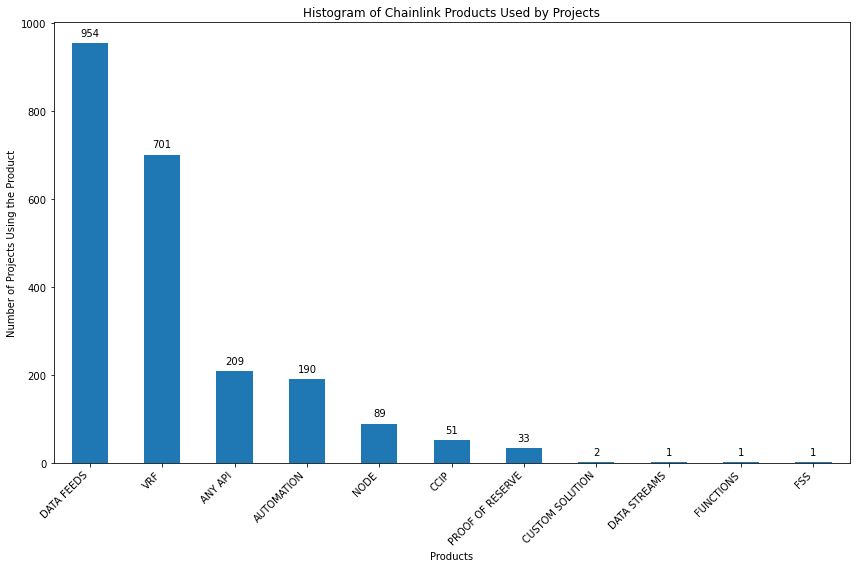

In [29]:
df = pd.read_csv('Chainlink_updated.csv', index_col=0)

all_products = df['Product(s)'].str.split(', ').explode()
product_counts = all_products.value_counts()

# Plot the histogram
plt.figure(figsize=(12, 8))
ax = product_counts.plot(kind='bar')

# Add count on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Histogram of Chainlink Products Used by Projects')
plt.xlabel('Products')
plt.ylabel('Number of Projects Using the Product')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:
# Save the figure
plt.savefig('chainlink_products_histogram.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

### Chart 2: Number of projects by category and products they use

In [36]:
import pandas as pd
import plotly.graph_objects as go

# Filter out rows where 'Category' or 'Product(s)' is not a string
df = df[df['Category'].apply(lambda x: isinstance(x, str))]
df = df[df['Product(s)'].apply(lambda x: isinstance(x, str))]

# Prepare the data for Sankey
all_categories = df['Category'].apply(lambda x: x.split(', ') if ',' in x else [x]).explode().unique().tolist()
all_products = df['Product(s)'].apply(lambda x: x.split(', ') if ',' in x else [x]).explode().unique().tolist()

# Define source and target for Sankey
source_indices = []
target_indices = []
values = []

for idx, row in df.iterrows():
    categories = row['Category'].split(', ') if ',' in row['Category'] else [row['Category']]
    products = row['Product(s)'].split(', ') if ',' in row['Product(s)'] else [row['Product(s)']]
    for cat in categories:
        for prod in products:
            source_indices.append(all_categories.index(cat))
            target_indices.append(len(all_categories) + all_products.index(prod))
            values.append(1)  # Each project contributes '1' to the link

# Create a custom color palette
node_colors = ['#1f77b4'] * len(all_categories) + ['#ff7f0e'] * len(all_products)

# Plot the enhanced Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_categories + all_products,
        color=node_colors
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))

fig.update_layout(title_text="Projects by Category and Product", font_size=10, width=1200, height=800)
fig.show()



In [ ]:
plt.savefig('chainlink_sankey_projectsandproducts.png', dpi=300, bbox_inches='tight')

### Chart 3: Filtered Chart 2 for Top 10 Categories for better visualization

#### Note: Even though we selected the top 10 categories, projects within those categories might still belong to other categories that are not in the top 10.

In [40]:
# Filter out rows where 'Category' or 'Product(s)' is not a string
df = df[df['Category'].apply(lambda x: isinstance(x, str))]
df = df[df['Product(s)'].apply(lambda x: isinstance(x, str))]

# Find the top 10 categories by frequency
top_10_categories = df['Category'].explode().value_counts().head(10).index.tolist()

# Strictly filter the dataframe to projects that ONLY belong to the top 10 categories
def only_top_categories(categories):
    category_set = set(categories.split(', '))
    return category_set.issubset(top_10_categories)

df_top_10 = df[df['Category'].apply(only_top_categories)]

# Prepare the data for Sankey
all_categories = df_top_10['Category'].apply(lambda x: x.split(', ') if ',' in x else [x]).explode().unique().tolist()
all_products = df_top_10['Product(s)'].apply(lambda x: x.split(', ') if ',' in x else [x]).explode().unique().tolist()

# Define source and target for Sankey
source_indices = []
target_indices = []
values = []

for idx, row in df_top_10.iterrows():
    categories = row['Category'].split(', ') if ',' in row['Category'] else [row['Category']]
    products = row['Product(s)'].split(', ') if ',' in row['Product(s)'] else [row['Product(s)']]
    for cat in categories:
        for prod in products:
            source_indices.append(all_categories.index(cat))
            target_indices.append(len(all_categories) + all_products.index(prod))
            values.append(1)  # Each project contributes '1' to the link

# Create a custom color palette
node_colors = ['#1f77b4'] * len(all_categories) + ['#ff7f0e'] * len(all_products)

# Plot the enhanced Sankey diagram for top 10 categories
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_categories + all_products,
        color=node_colors
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))

fig.update_layout(title_text="Top 10 Categories: Sankey Diagram of Projects by Category and Product", font_size=10, width=1200, height=800)
fig.show()


In [ ]:
plt.savefig('chainlink_sankey_projectsandproducts_top10.png', dpi=300, bbox_inches='tight')

### Chart 4: Bar chart based on the top 20 categories (including combinations)

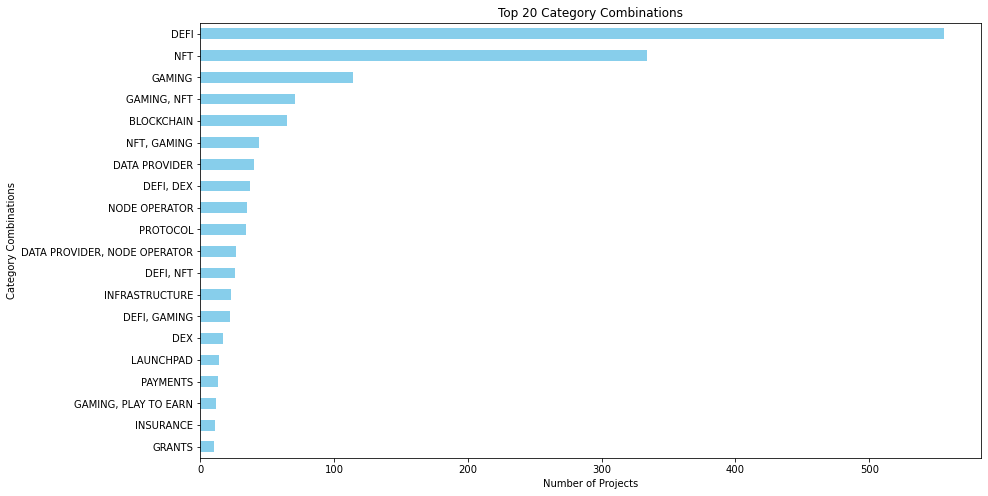

In [44]:
# Filter out rows where 'Category' is not a string
df = df[df['Category'].apply(lambda x: isinstance(x, str))]

# Count the frequency of each combination category
combination_counts = df['Category'].value_counts()

# Select the top 20 combination categories
top_20_combinations = combination_counts.head(20)

# Plot the bar chart
plt.figure(figsize=(14, 8))
top_20_combinations.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()  # Display the highest counts at the top
plt.title('Top 20 Category Combinations')
plt.xlabel('Number of Projects')
plt.ylabel('Category Combinations')
plt.show()

In [ ]:
plt.savefig('chainlink_Top20_ProjectCategories.png', dpi=300, bbox_inches='tight')

### Chart 5: Bar chart based on all categories (filtered out categories with < 5 projects)

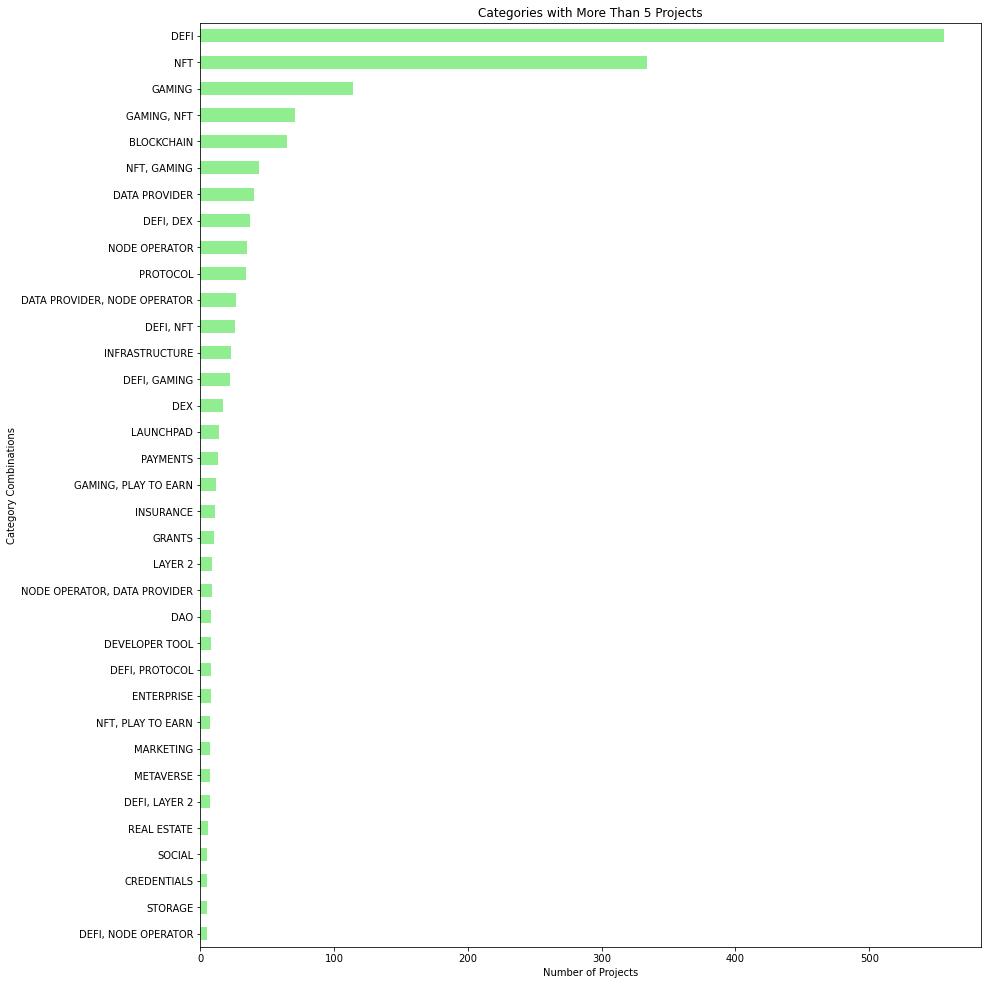

In [49]:
# Filter out rows where 'Category' is not a string
df = df[df['Category'].apply(lambda x: isinstance(x, str))]

# Count the frequency of each combination category
combination_counts = df['Category'].value_counts()

# Filter out combinations with less than 5 occurrences
filtered_counts = combination_counts[combination_counts >= 5]

# Plot the bar chart
plt.figure(figsize=(14, len(filtered_counts) // 2))  # Adjust the plot height based on the number of categories
filtered_counts.plot(kind='barh', color='lightgreen')
plt.gca().invert_yaxis()  # Display the highest counts at the top
plt.title('Categories with More Than 5 Projects')
plt.xlabel('Number of Projects')
plt.ylabel('Category Combinations')
plt.show()

In [ ]:
plt.savefig('chainlink_ProjectCategories_Filtered.png', dpi=300, bbox_inches='tight')

### Chart 6: Project Status Distribution: Live vs. Intent

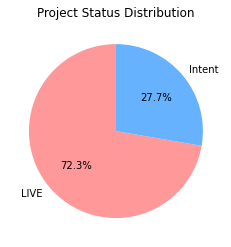

In [50]:
# Replace blank spaces in the 'Status' column with 'Intent'
df['Status'].fillna('Intent', inplace=True)

# 1. Pie Chart for Project Status
status_counts = df['Status'].value_counts()
status_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99'])
plt.title("Project Status Distribution")
plt.ylabel('')  # Remove the y-axis label for cleaner visualization
plt.show()

In [ ]:
plt.savefig('Chainlink_ProjectStatusDistribution.png', dpi=300, bbox_inches='tight')

### Chart 7: Distribution of Product Categories and Status

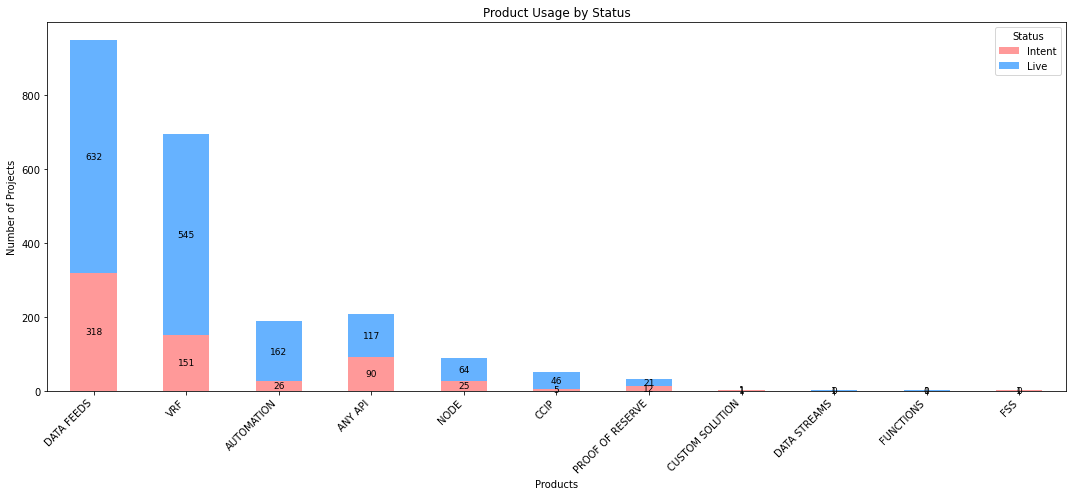

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you've already read your data into a DataFrame named df

# Replace 'LIVE' with 'Live' and NaN values with 'Intent' in the 'Status' column
df['Status'] = df['Status'].replace('LIVE', 'Live').fillna('Intent')

# Expand rows with multiple products into individual rows
all_rows = []
for _, row in df.iterrows():
    products = row['Product(s)'].split(", ")
    for product in products:
        all_rows.append([product, row['Status']])
expanded_df = pd.DataFrame(all_rows, columns=['Product', 'Status'])


# 2. Stacked Bar Chart for Product Usage by Status with Annotations
# Create a crosstab of the product and status columns from the expanded DataFrame
product_status = pd.crosstab(expanded_df['Product'], expanded_df['Status'])

# If 'Live' column doesn't exist in product_status, create it
if 'Live' not in product_status.columns:
    product_status['Live'] = 0

# Sort values by the 'Live' column
product_status = product_status.sort_values(by='Live', ascending=False)

# Plot the stacked bar chart
ax = product_status.plot(kind='bar', stacked=True, figsize=(15,7), color=['#FF9999', '#66B2FF'])
plt.title("Product Usage by Status")
plt.ylabel("Number of Projects")
plt.xlabel("Products")
plt.xticks(rotation=45, ha='right')

# Annotating the bar segments with their respective counts
for container in ax.containers:
    for rect in container.patches:
        height = rect.get_height()
        ax.annotate(f'{int(height)}', 
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    xytext=(0, 0),  # offset
                    textcoords="offset points",
                    ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()






In [ ]:
plt.savefig('Chainlink_ProjectStatusDistributionByProducts.png', dpi=300, bbox_inches='tight')